<a href="https://colab.research.google.com/github/panzershracker/Deep-learning-in-comp.-vision/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к уроку №3. Евдокимов Алексей

# Задание

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Загрузка датасета food-101

In [0]:
# tfds.disable_progress_bar()

(train_df, test_df), df_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

In [121]:
df_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

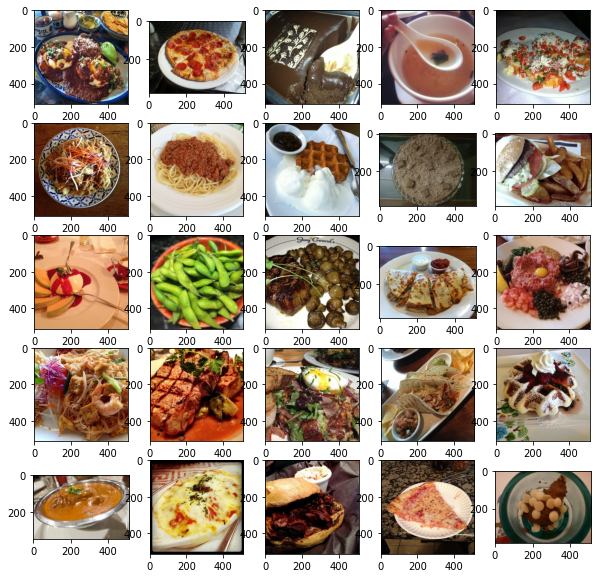

In [122]:
samples = [i[0] for i in iter(train_df.take(25))]

fig = plt.figure(figsize=[10,10])

for i in range(len(samples)):
  ax = fig.add_subplot(5,5, 1+i)
  ax.imshow(samples[i])
  # plt.xticks([]), plt.yticks([])

In [123]:
samples[0].shape

TensorShape([512, 512, 3])

# Создание пайплайна


In [0]:
IMSIZE = 160
EPOCHS = 10
BATCH = 64

def prepare(img, label):
  img = tf.cast(img, tf.float32) / 127 - 1
  return tf.image.resize(img, (IMSIZE, IMSIZE)), label

# def augmentation(img, label):
#   img, label = prepare(img, label)
#   img = tf.image.random_brightness(img, 0.3)
#   img = tf.image.random_flip_left_right(img)
#   img = tf.image.random_flip_up_down(img)

#   return img, label

In [0]:
train_df = train_df.shuffle(buffer_size=1000)
train_df = train_df.map(prepare)
train_df = train_df.batch(BATCH, drop_remainder=True)

test_df = test_df.shuffle(buffer_size=1000)
test_df = test_df.map(prepare)
test_df = test_df.batch(128, drop_remainder=True)

In [0]:
NAME = 'Transfer'

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMSIZE, IMSIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax')
])

# Подготовка к обучению

In [0]:
LEARNING_RATE = 0.0001

optimazer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimazer,
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/' + NAME,
    write_graph=False,
    update_freq=100,
    profile_batch=0
)

In [129]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


#Обучение Модели


In [130]:
%%time

model.fit(
    train_df,
    epochs=EPOCHS,
    validation_data=test_df,
    callbacks=tensorboard_callback
)

Epoch 1/10
1065/1065 [==============================] - 286s 269ms/step - loss: 2.1913 - accuracy: 0.4713 - val_loss: 1.8694 - val_accuracy: 0.5270
Epoch 2/10
1065/1065 [==============================] - 283s 266ms/step - loss: 1.1865 - accuracy: 0.6876 - val_loss: 1.5223 - val_accuracy: 0.6075
Epoch 3/10
1065/1065 [==============================] - 283s 266ms/step - loss: 0.8047 - accuracy: 0.7864 - val_loss: 1.5105 - val_accuracy: 0.6225
Epoch 4/10
1065/1065 [==============================] - 282s 265ms/step - loss: 0.5407 - accuracy: 0.8568 - val_loss: 1.5903 - val_accuracy: 0.6147
Epoch 5/10
1065/1065 [==============================] - 288s 270ms/step - loss: 0.3455 - accuracy: 0.9112 - val_loss: 1.6028 - val_accuracy: 0.6243
Epoch 6/10
1065/1065 [==============================] - 285s 268ms/step - loss: 0.2177 - accuracy: 0.9469 - val_loss: 1.7934 - val_accuracy: 0.6132
Epoch 7/10
1065/1065 [==============================] - 284s 267ms/step - loss: 0.1418 - accuracy: 0.9664 - val_

In [131]:
model.evaluate(test_df)

59/59 [==============================] - 16s 275ms/step - loss: 2.0636 - accuracy: 0.6245


[2.063643217086792, 0.6244703531265259]

In [132]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

# Предсказание на своем изображении

In [0]:
import imageio 
from skimage.transform import resize

def prepare_image(img):
  img = img.astype(np.float32) / 127 - 1
  img = resize(img, (IMSIZE, IMSIZE), order=3, mode='reflect', anti_aliasing=True)
  return img.astype(np.float32)

In [143]:
!wget https://www.macheesmo.com/wp-content/uploads/2017/05/Grilled-Quesadilla-Taco-Shells-Feature.jpg
!wget https://images-gmi-pmc.edge-generalmills.com/e59f255c-7498-4b84-9c9d-e578bf5d88fc.jpg

--2020-06-02 15:37:14--  https://www.macheesmo.com/wp-content/uploads/2017/05/Grilled-Quesadilla-Taco-Shells-Feature.jpg
Resolving www.macheesmo.com (www.macheesmo.com)... 172.67.68.249, 104.26.8.248, 104.26.9.248, ...
Connecting to www.macheesmo.com (www.macheesmo.com)|172.67.68.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147235 (144K) [image/jpeg]
Saving to: ‘Grilled-Quesadilla-Taco-Shells-Feature.jpg.4’

Grilled-Quesadilla- 100%[===================>] 143.78K  --.-KB/s    in 0.003s  

2020-06-02 15:37:14 (46.1 MB/s) - ‘Grilled-Quesadilla-Taco-Shells-Feature.jpg.4’ saved [147235/147235]

--2020-06-02 15:37:17--  https://images-gmi-pmc.edge-generalmills.com/e59f255c-7498-4b84-9c9d-e578bf5d88fc.jpg
Resolving images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)... 192.229.144.76
Connecting to images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)|192.229.144.76|:443... connected.
HTTP request sent, awaiting res

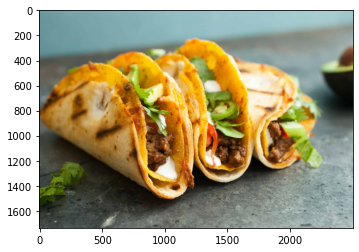

In [140]:
img = imageio.imread('Grilled-Quesadilla-Taco-Shells-Feature.jpg', pilmode='RGB')
plt.imshow(img)

img = prepare_image(img)

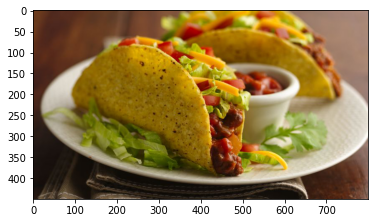

In [144]:
img2 = imageio.imread('e59f255c-7498-4b84-9c9d-e578bf5d88fc.jpg')
plt.imshow(img2)

img2 = prepare_image(img2)

In [0]:
pred = model(img[None, ...], training=False)
pred_label = pred.numpy().argmax()

In [0]:
pred2 = model(img2[None, ...], training=False)
pred_label2 = pred2.numpy().argmax()

In [148]:
df_info.features['label'].int2str(pred_label)

'tacos'

In [149]:
df_info.features['label'].int2str(pred_label2)

'tacos'